In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import matplotlib as mpl
from mpltools import annotation
import time

from matplotlib import rc
import seaborn as sns
custom_params = {
    "xtick.direction": "in",
    "ytick.direction": "in",
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 0.3,
    "figure.dpi": 200,
    "text.usetex": True,
    "font.family": "serif",
}

sns.set_theme(context = "notebook", style="ticks", rc=custom_params)

BlueUB = (0, 157/255, 224/255)
BrownUB = (68/255, 58/255, 49/255)

# Instance of the Langevin class and trajectory calculation (See chapter $2$) :

In [2]:
from Overdamped_Langevin import Langevin

tc_0 = time.time() 
brown = Langevin(dt=0.01, Nt=100_000, a=1.5e-6) 
brown.trajectory()
print("Compute time= ", time.time()-tc_0)

Compute time=  46.222177267074585


## Standard deviation $\langle X_n^2 \rangle$

In [3]:
delta_t, msd = brown.MSD() 
dt_theo = np.linspace(brown.dt*1e-1, brown.dt*brown.Nt*1e1, 100)

## Deplacements distribution P($\Delta X_n$)

In [21]:
i_tau = 10
sigma = np.sqrt(2*brown.D0*i_tau*brown.dt)
delta_Xtau = brown.Xn[i_tau:]-brown.Xn[:-i_tau]
x = np.linspace(-5* sigma, 5 * sigma, 1000)
p_gauss = 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-x ** 2 / (2 * sigma ** 2))

## Figures

### 1) Trajectrory

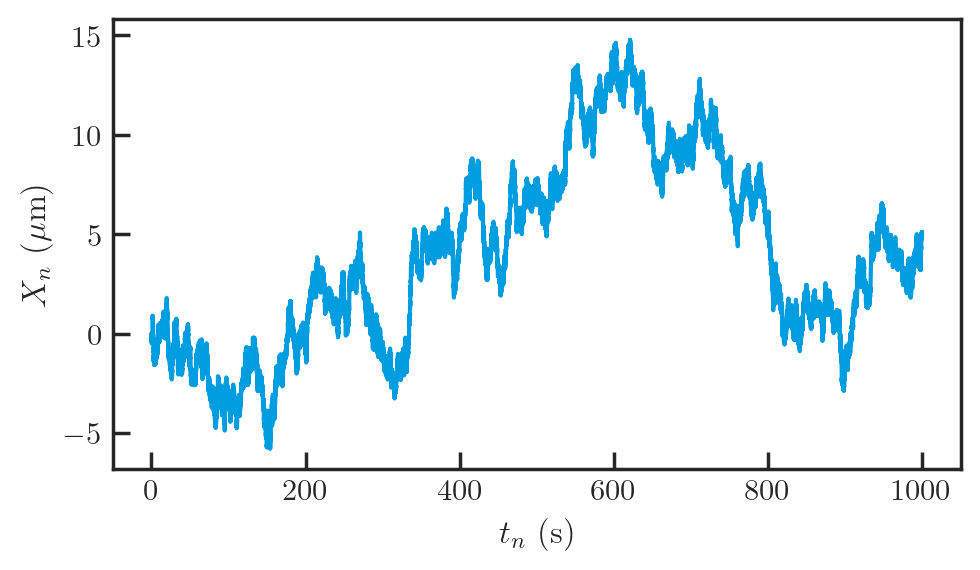

In [7]:
plt.figure(figsize=(1.5 * 3.375, 1.5 * 3.375 / 1.68), tight_layout=True)
plt.plot(brown.t, brown.Xn*1e6, color=BlueUB)
plt.xlabel(r"$t_n~(\mathrm{s})$")
plt.ylabel(r"$X_n~(\mathrm{\mu m})$")
plt.savefig("Trajectoire.pdf")

### 2) $\langle X_n^2 \rangle$ and P($\Delta X_n$)

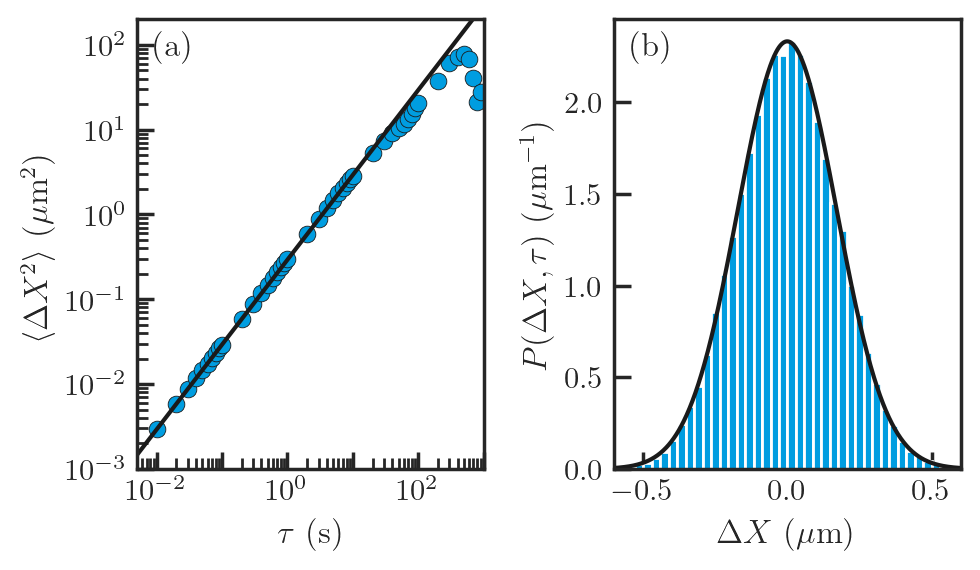

In [22]:
plt.figure(figsize=(1.5 * 3.375, 1.5 * 3.375 / 1.68), tight_layout=True)

ax1 = plt.subplot(121)
ax1.loglog(delta_t, msd*1e12, "o", color=BlueUB)
ax1.plot(dt_theo, 2*brown.D0*dt_theo*1e12, "k-")
ax1.set(
    xlabel = r"$\tau~(\mathrm{s})$",
    ylabel = r"$\langle \Delta X^2 \rangle~(\mathrm{\mu m}^2)$",
    xlim=(brown.dt/2, brown.dt*brown.Nt),
    ylim=(1e-15*1e12, 2e-10*1e12),
    xticks = (1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3),
)
ax1.text(0.05, 0.92, r"(a)", transform=ax1.transAxes)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax1_ticks = ax1.get_xticklabels()
for i in ax1_ticks:
    i.set_visible(False)
for n, i in enumerate(ax1_ticks):
    if n%2==0:i.set_visible(True)


ax2 = plt.subplot(122)
ax2.hist(delta_Xtau*1e6, bins=50, density=True, color=BlueUB)
ax2.plot(x*1e6, p_gauss / np.trapz(p_gauss, x*1e6), "k-")
ax2.set(
    xlabel = r"$\Delta X~(\mathrm{\mu m})$", 
    ylabel = r"$P(\Delta X, \tau) ~(\mathrm{\mu m}^{-1})$",
    xlim = (-6e-1,6e-1),
)
ax2.text(0.05, 0.92, r"(b)", transform=ax2.transAxes)

plt.savefig("Annalyse.pdf")

### 3) Gaussian probability

In [17]:
i_tau_list = np.array([1, 10, 100, 500, 1_000, 5_000])
marqueurs = ['o', 's', 'D', '^', 'v', 'p', 'h']

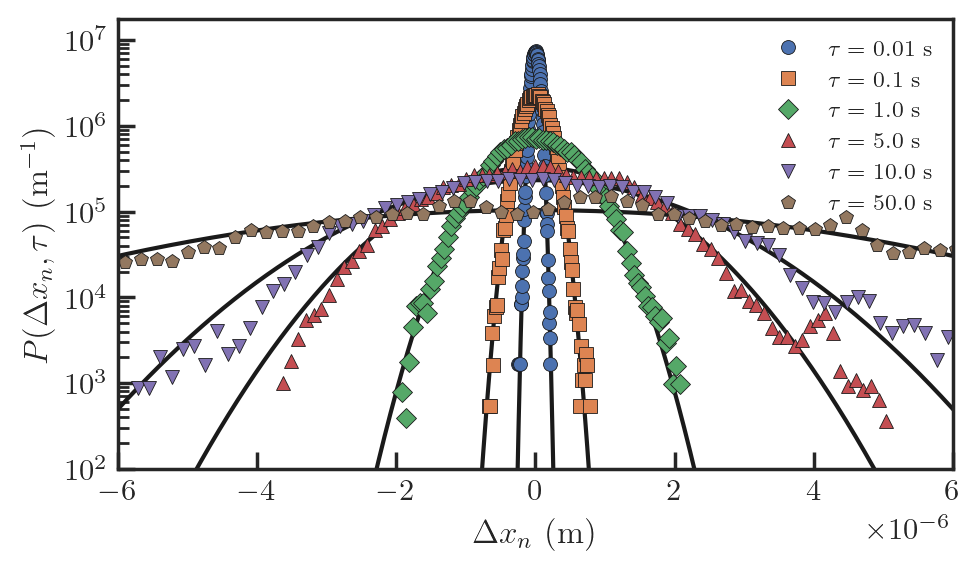

In [23]:
plt.figure(figsize=(1.5 * 3.375, 1.5 * 3.375 / 1.68), tight_layout=True)
ax1 = plt.subplot(111)

for n, i_tau in enumerate(i_tau_list):
    sigma = np.sqrt(2*brown.D0*i_tau*brown.dt)
    delta_X_tau = brown.Xn[i_tau:]-brown.Xn[:-i_tau]
    Ntau = len(delta_X_tau)
    #Simulation
    hist, bins = np.histogram(delta_X_tau, bins=80, density=False)
    bins_center = (bins[1:] + bins[:-1]) / 2
    PDF_normalised = hist/np.trapz(hist,bins_center)
    errHist = hist/np.sqrt(Ntau)
    errPDF_normalised = errHist/np.trapz(errHist,bins_center)
    #Theory
    x = np.linspace(-5* sigma, 5 * sigma, 1000)
    p_gauss = 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-x ** 2 / (2 * sigma ** 2))

    Tau = i_tau*brown.dt
    label = r"$\tau =$ " + str(Tau) + " s"
    ax1.errorbar(x=bins_center, y=PDF_normalised,
                 # yerr=errPDF_normalised, 
                 marker=marqueurs[n], linestyle=" ", label=label, markersize=5)
    ax1.semilogy(x, p_gauss, "k-")
    
ax1.set(
    xlabel = r"$\Delta x_{n} ~(\mathrm{ m})$", 
    ylabel = r"$P(\Delta x_{n},\tau)~(\mathrm{m}^{-1})$",
    xlim = (-6e-6,6e-6),
    ylim = (1e2,None),
)
ax1.legend(loc='upper right',fontsize=8,frameon=False)

plt.savefig("Proba_gauss_bulk.pdf")

# Gaussian probability with drift (see chapter $3$) :

In [20]:
from Overdamped_Langevin import Langevin

tc_0 = time.time() 
brown = Langevin(dt=0.01, Nt=100_000, a=1.5e-6, gravity=True, signe="+")
brown.trajectory()
print("Compute time= ", time.time()-tc_0)

Compute time=  48.36022615432739


In [21]:
# import matplotlib.image as mpimg ###
from PIL import Image
import fitz
import io

In [22]:
pdf_file = fitz.open('SchemaSedimentationBulk.pdf')
# in case there is a need to loop through multiple PDF pages
for page_number in range(len(pdf_file)):
    page = pdf_file[page_number]
    rgb = page.get_pixmap()
    pil_image = Image.open(io.BytesIO(rgb.tobytes()))

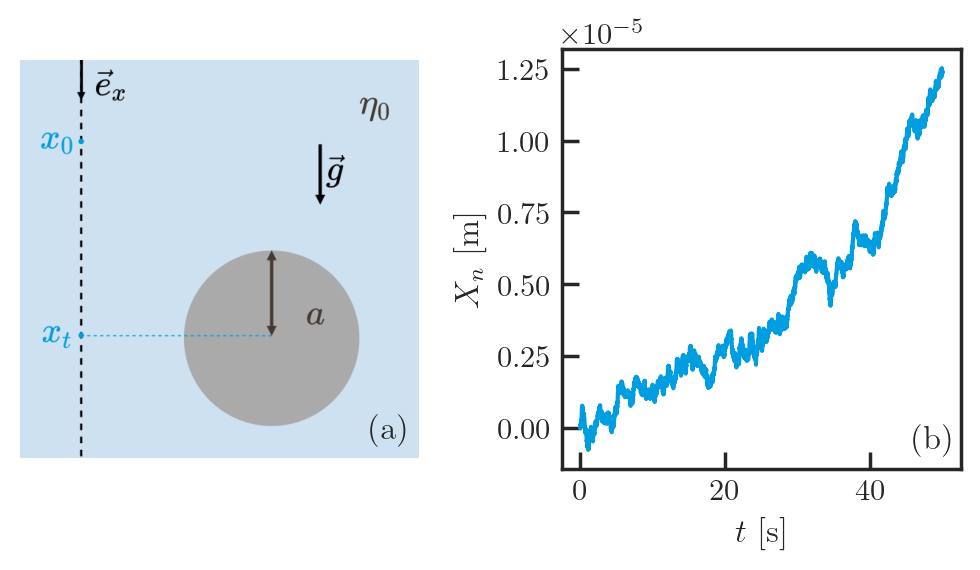

In [23]:
plt.figure(figsize=(1.5 * 3.375, 1.5 * 3.375 / 1.68), tight_layout=True)

ax0 = plt.subplot(121)
ax0.imshow(pil_image.convert('RGB'))
ax0.axes.get_xaxis().set_visible(False)
ax0.axes.get_yaxis().set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.spines['left'].set_visible(False)
ax0.text(0.88, 0.05, r"(a)", transform=ax0.transAxes)

ax1 = plt.subplot(122)
P=5000
ax1.plot(brown.t[:P], brown.Xn[:P], color=BlueUB)
ax1.set(
    xlabel = r"$t~[\mathrm{ s}]$", 
    ylabel = r"$X_{n}~[\mathrm{m}]$",
    # xlim = (-27e-6,5e-6),
    # ylim = (1e2,None),
)
ax1.text(0.88, 0.05, r"(b)", transform=ax1.transAxes)
plt.savefig("Traj_bulk_drift.pdf")

In [24]:
i_tau_list = np.array([1, 10, 100, 500, 1_000, 5_000])
marqueurs = ['o', 's', 'D', '^', 'v', 'p', 'h']

In [25]:
U = brown.U
U

2.783698624420983e-07

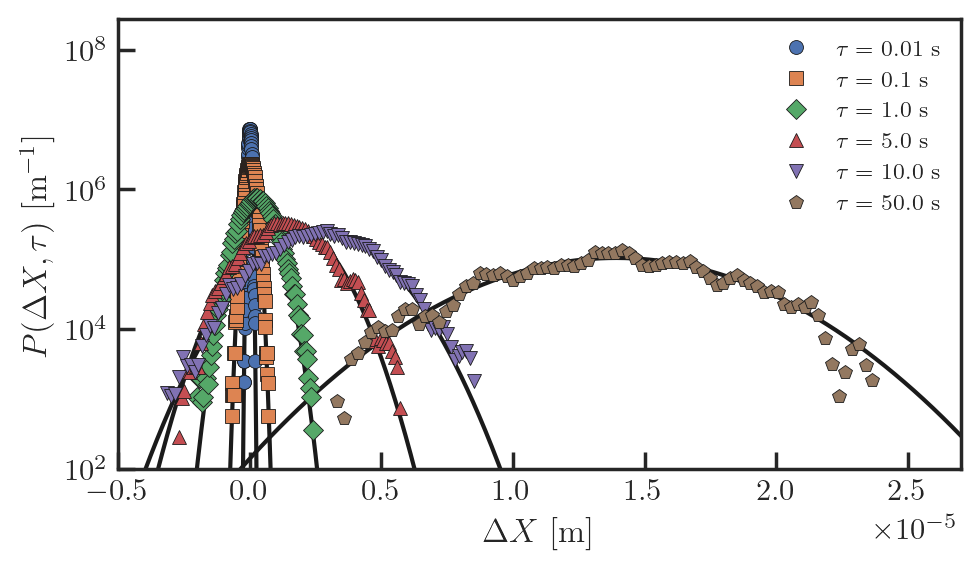

In [26]:
plt.figure(figsize=(1.5 * 3.375, 1.5 * 3.375 / 1.68), tight_layout=True)
ax1 = plt.subplot(111)

for n, i_tau in enumerate(i_tau_list):
    sigma = np.sqrt(2*brown.D0*i_tau*brown.dt)
    delta_Xtau = brown.Xn[i_tau:]-brown.Xn[:-i_tau]
    Ntau = len(delta_Xtau)
    #Simulation
    hist, bins = np.histogram(delta_Xtau, bins=80, density=False)
    bins_center = (bins[1:] + bins[:-1]) / 2
    PDF_normalised = hist/np.trapz(hist,bins_center)
    errHist = hist/np.sqrt(Ntau)
    errPDF_normalised = errHist/np.trapz(errHist,bins_center)
    #Theory
    x = np.linspace(-8*sigma, 8*sigma, 1000)
    p_gauss = 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-(x -U*i_tau*brown.dt) ** 2 / (2 * sigma ** 2))

    Tau_i = i_tau*brown.dt
    label = r"$\tau =$ " + str(Tau_i) + " s"
    ax1.errorbar(x=bins_center, y=PDF_normalised,
                 # yerr=errPDF_normalised, 
                 marker=marqueurs[n], linestyle=" ", label=label, markersize=5)
    ax1.semilogy(x, p_gauss, "k-")
    
ax1.set(
    xlabel = r"$\Delta X~[\mathrm{ m}]$", 
    ylabel = r"$P(\Delta X,\tau)~[\mathrm{m}^{-1}]$",
    # xlim = (-27e-6,5e-6),
    xlim = (-5e-6,27e-6),
    ylim = (1e2,None),
)
ax1.legend(loc='upper right',fontsize=8,frameon=False)

plt.savefig("Proba_gauss_bulk_drift.pdf")

## $1$st moment

In [27]:
list_i_tau = np.array([], dtype=int) #Liste des entiers Ntau tel que tau = Ntau*dt
for i in range(len(str(brown.Nt)) - 1):
    list_i_tau = np.concatenate(
        (
            list_i_tau,
            np.arange(10 ** i, 10 ** (i + 1), 10 ** i, dtype=int),
        )
    )

In [28]:
tau_theo = np.logspace(-3,4, 100)

moments = {} #Dictionnary of all moments wanted with integrate methode : key = ordrer
Moments = {} #Dictionnary of all moments wanted with np.mean() methode : key = order

In [29]:
m = 1 #moment order choose
moments[str(m)] = np.zeros(len(list_i_tau))
Moments[str(m)] = np.zeros(len(list_i_tau))
bins = 200
for n, i in enumerate(list_i_tau):
    if i == 0:
        moments[str(m)][n] = 0
        Moments[str(m)][n] = 0
        continue
    Xi_datas = brown.Xn[i:] - brown.Xn[:-i]
    #Integrate methode
    hist, Xi = np.histogram(Xi_datas, bins=bins, density=False)
    Xi_centered = (Xi[1:] + Xi[:-1]) / 2
    P_Xi = hist/np.trapz(hist,Xi_centered)
    moments[str(m)][n] = np.trapz(  Xi_centered**m * P_Xi , Xi_centered)
    #Average methode
    Moments[str(m)][n] = np.mean(Xi_datas**m)

## $2$nd moment

In [30]:
m = 2 #moment order choosen
moments[str(m)] = np.zeros(len(list_i_tau))
Moments[str(m)] = np.zeros(len(list_i_tau))
bins = 200
for n, i in enumerate(list_i_tau):
    if i == 0:
        moments[str(m)][n] = 0
        Moments[str(m)][n] = 0
        continue
    Xi_datas = brown.Xn[i:] - brown.Xn[:-i]
    #Integrate methode
    hist, Xi = np.histogram(Xi_datas, bins=bins, density=False)
    Xi_centered = (Xi[1:] + Xi[:-1]) / 2
    P_Xi = hist/np.trapz(hist,Xi_centered)
    moments[str(m)][n] = np.trapz(  Xi_centered**m * P_Xi , Xi_centered)
    #Average methode
    Moments[str(m)][n] = np.mean(Xi_datas**m)
    
# """
# It is possible to use the methode "brown.MSD()" of the Langevin class to compute automatically Moments["2"] as:
# tau, msd = brown.MSD()
# """

In [86]:
x1theo = U*tau_theo
x2theo = 2*brown.D0*tau_theo+U**2*tau_theo**2

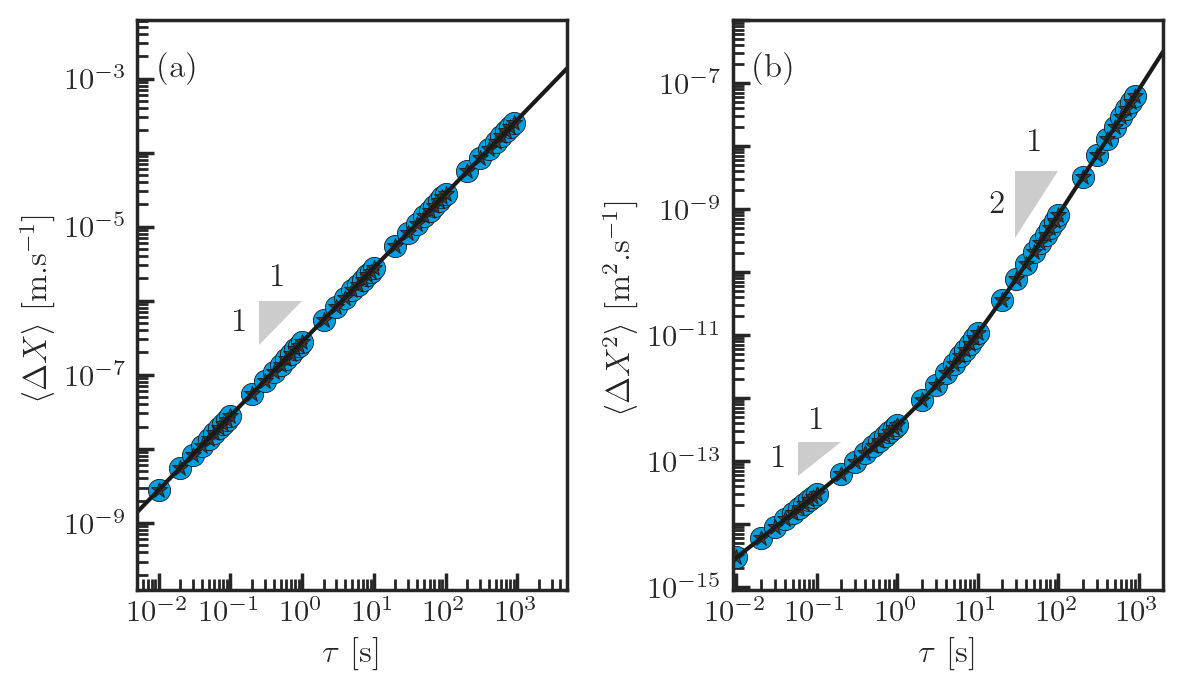

In [87]:
plt.figure(figsize=(1.8 * 3.375, 1.8 * 3.375 / 1.68), tight_layout=True)


ax0 = plt.subplot(121)
ax0.loglog(brown.dt*list_i_tau, Moments["1"], "o", color=BlueUB, markersize=8, label=r"$\langle x_i^2 \rangle_n$")
ax0.plot(brown.dt*list_i_tau, moments["1"], "*", color=BrownUB, markersize=6, label=r"$\langle x_i^2 \rangle$")
ax0.plot(tau_theo, x1theo, "k-")
ax0.set(
    xlabel = r"$\tau~[\mathrm{s}]$",
    ylabel = r"$\langle \Delta  X  \rangle ~[\mathrm{m}.\mathrm{s}^{-1}]$",
    xlim=(5e-3, 5e3),
    # ylim=(-0.0005, None),
)
annotation.slope_marker((1, 1e-6), (1, 1), ax=ax0, invert=True)
ax0.text(0.05, 0.90, r"(a)", transform=ax0.transAxes)
# ax0.legend(loc='lower right', frameon=False, fontsize=10)

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax0.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax0.yaxis.set_minor_locator(locmin)
ax0.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax0.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax0.xaxis.set_minor_locator(locmin)
ax0.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax0_ticks = ax0.get_yticklabels()
for i in ax0_ticks:
    i.set_visible(False)
for n, i in enumerate(ax0_ticks):
    if n%2==0:i.set_visible(True)
    
    ##################################################

ax1 = plt.subplot(122)
ax1.loglog(brown.dt*list_i_tau, Moments["2"], "o", color=BlueUB, markersize=8)
ax1.loglog(brown.dt*list_i_tau, moments["2"], "*", color=BrownUB, markersize=6)
ax1.plot(tau_theo, x2theo, "k-")
ax1.set(
    xlabel = r"$\tau~[\mathrm{s}]$",
    ylabel = r"$\langle \Delta X^2 \rangle ~[\mathrm{m}^{2}.\mathrm{s}^{-1}]$",
    xlim=(9e-3, 2e3),
    ylim=(9e-16,1e-6),
    # xticks = (1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3),
)
annotation.slope_marker((2e-1, 2e-13), (1, 1), ax=ax1, invert=True)
annotation.slope_marker((1e2, 4e-9), (2, 1), ax=ax1, invert=True)
ax1.text(0.05, 0.90, r"(b)", transform=ax1.transAxes)

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax1.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax1.yaxis.set_minor_locator(locmin)
ax1.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax1.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax1_ticks = ax1.get_yticklabels()
for i in ax1_ticks:
    i.set_visible(False)
for n, i in enumerate(ax1_ticks):
    if n%2==0:i.set_visible(True)

plt.savefig("Moments_bulk_drift.pdf")

# $3$rd moment

In [32]:
m = 3 #moment order choosen
moments[str(m)] = np.zeros(len(list_i_tau))
# Moments[str(m)] = np.zeros(len(list_i_tau))
bins = 200
for n, i in enumerate(list_i_tau):
    if i == 0:
        moments[str(m)][n] = 0
        Moments[str(m)][n] = 0
        continue
    Xi_datas = brown.Xn[i:] - brown.Xn[:-i]
    #Integrate methode
    hist, Xi = np.histogram(Xi_datas, bins=bins, density=False)
    Xi_centered = (Xi[1:] + Xi[:-1]) / 2
    P_Xi = hist/np.trapz(hist,Xi_centered)
    moments[str(m)][n] = np.trapz(  Xi_centered**m * P_Xi , Xi_centered)
    #Average methode
    # Moments[str(m)][n] = np.mean(Xi_datas**m)
    

# $4$th moments

In [35]:
m = 4 #moment order choosen
moments[str(m)] = np.zeros(len(list_i_tau))
bins = 200
for n, i in enumerate(list_i_tau):
    if i == 0:
        moments[str(m)][n] = 0
        _datas = brown.Xn[i:] - brown.Xn[:-i]
    #Integrate methode
    hist, Xi = np.histogram(Xi_datas, bins=bins, density=False)
    Xi_centered = (Xi[1:] + Xi[:-1]) / 2
    P_Xi = hist/np.trapz(hist,Xi_centered)
    moments[str(m)][n] = np.trapz(  Xi_centered**m * P_Xi , Xi_centered)
    #Average m

In [84]:
x3theo = 6*brown.D0*U*tau_theo**2 + U**3*tau_theo**3
x4theo = 12*brown.D0**2*tau_theo**2 + 12*brown.D0*U**2*tau_theo**3 + U**4*tau_theo**4

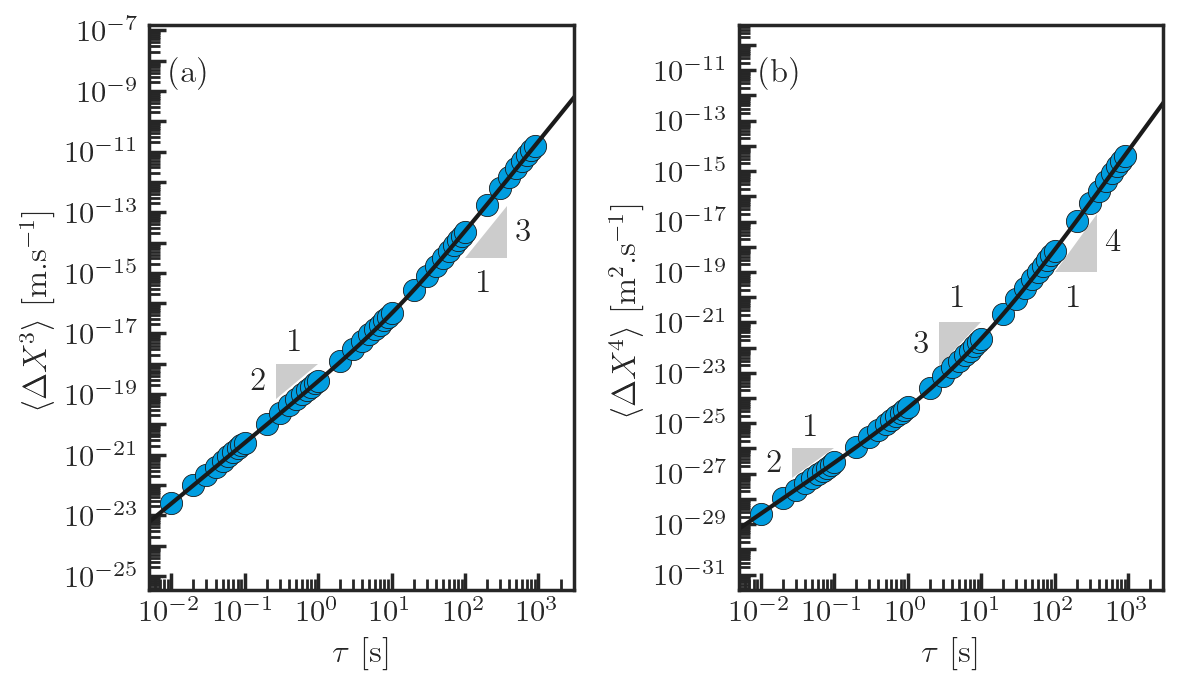

In [156]:
plt.figure(figsize=(1.8 * 3.375, 1.8 * 3.375 / 1.68), tight_layout=True)
taille_marques=8

ax0 = plt.subplot(121)
ax0.loglog(brown.dt*list_i_tau, moments["3"], "o", color=BlueUB, markersize=taille_marques, label=r"$\langle x_i^2 \rangle$")
ax0.plot(tau_theo, x3theo, "k-")
ax0.set(
    xlabel = r"$\tau~[\mathrm{s}]$",
    ylabel = r"$\langle \Delta  X^3  \rangle ~[\mathrm{m}.\mathrm{s}^{-1}]$",
    xlim=(5e-3, 3e3),
    # ylim=(-0.0005, None),
)
annotation.slope_marker((1, 1e-18), (2, 1), ax=ax0, invert=True)
annotation.slope_marker((100, 3e-15), (3, 1), ax=ax0, invert=False)
ax0.text(0.05, 0.90, r"(a)", transform=ax0.transAxes)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax0.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax0.yaxis.set_minor_locator(locmin)
ax0.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax0.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax0.xaxis.set_minor_locator(locmin)
ax0.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax0_ticks = ax0.get_yticklabels()
for i in ax0_ticks:
    i.set_visible(False)
for n, i in enumerate(ax0_ticks):
    if n%2==0:i.set_visible(True)
    
    ##################################################

ax1 = plt.subplot(122)
ax1.loglog(brown.dt*list_i_tau, moments["4"], "o", color=BlueUB, markersize=taille_marques)
ax1.plot(tau_theo, x4theo, "k-")
ax1.set(
    xlabel = r"$\tau~[\mathrm{s}]$",
    ylabel = r"$\langle \Delta X^4 \rangle ~[\mathrm{m}^{2}.\mathrm{s}^{-1}]$",
    xlim=(5e-3, 3e3),
    # ylim=(9e-16,1e-6),
)
annotation.slope_marker((1e-1, 1e-26), (2, 1), ax=ax1, invert=True)
annotation.slope_marker((10, 1e-21), (3, 1), ax=ax1, invert=True)
annotation.slope_marker((100, 1e-19), (4, 1), ax=ax1, invert=False)
ax1.text(0.05, 0.90, r"(b)", transform=ax1.transAxes)

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax1.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax1.yaxis.set_minor_locator(locmin)
ax1.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax1.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax1_ticks = ax1.get_yticklabels()
for i in ax1_ticks:
    i.set_visible(False)
for n, i in enumerate(ax1_ticks):
    if n%2==0:i.set_visible(True)

plt.savefig("Moments34_bulk_drift.pdf")

## Case bulk (drift $U=0$) :

In [125]:
from Overdamped_Langevin import Langevin

tc_0 = time.time() 
brown = Langevin(dt=0.01, Nt=100_000, a=1.5e-6)
brown.trajectory()
print("Compute time= ", time.time()-tc_0)

Compute time=  46.35061192512512


In [126]:
m = np.linspace(1,4,4, dtype=int)  #moment order choose
moments_bulk = {}

for k in m:
    moments_bulk[str(k)] = np.zeros(len(list_i_tau))
    for n, i in enumerate(list_i_tau):
        if i == 0:
            moments_bulk[str(k)][n] = 0
            continue
        Xi_datas = brown.Xn[i:] - brown.Xn[:-i]
        # moments_bulk[str(k)][n] = np.mean(Xi_datas**k)
        
        hist, Xi = np.histogram(Xi_datas, bins=bins, density=False)
        Xi_centered = (Xi[1:] + Xi[:-1]) / 2
        P_Xi = hist/np.trapz(hist,Xi_centered)
        moments_bulk[str(k)][n] = np.trapz(  Xi_centered**k * P_Xi , Xi_centered)
        
moments_bulk["tau"] = list_i_tau*brown.dt

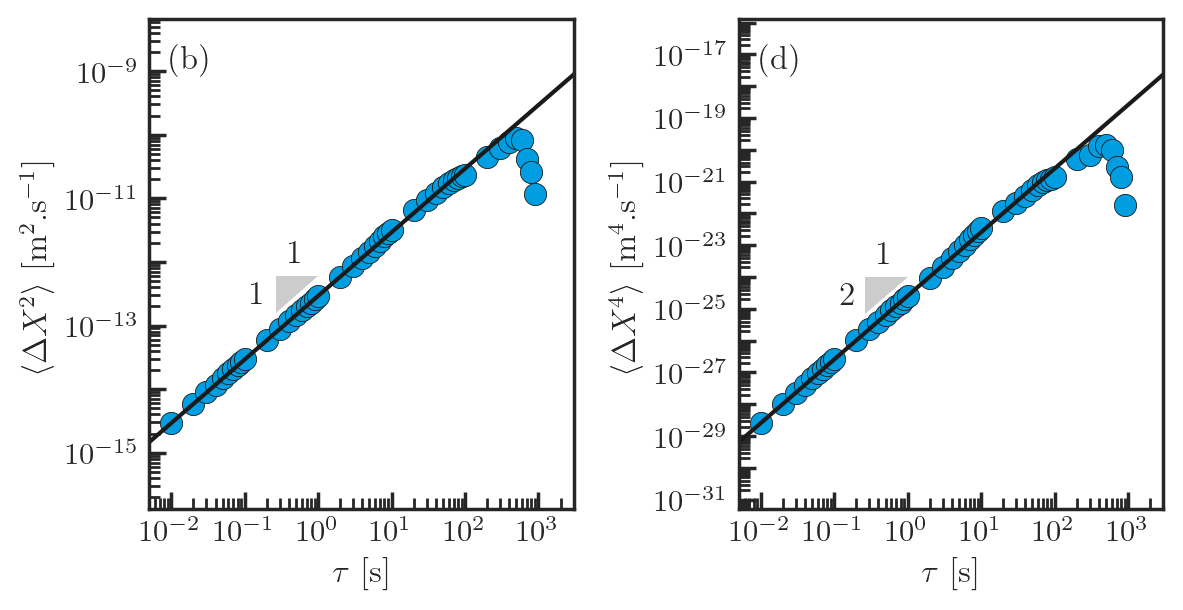

In [157]:
plt.figure(figsize=(1.8 * 3.375, 1.6* 3.375 / 1.68), tight_layout=True)
taille_marques=8

ax1 = plt.subplot(121)
ax1.loglog(moments_bulk["tau"], moments_bulk["2"], "o", color=BlueUB, markersize=taille_marques)
ax1.plot(tau_theo, 2*brown.D0*tau_theo, "k-")
ax1.set(
    xlabel = r"$\tau~[\mathrm{s}]$",
    ylabel = r"$\langle \Delta X^2 \rangle ~[\mathrm{m}^{2}.\mathrm{s}^{-1}]$",
    xlim=(5e-3, 3e3),
    # ylim=(9e-16,1e-6),
)
ax1.text(0.05, 0.90, r"(b)", transform=ax1.transAxes)
annotation.slope_marker((1, 6e-13), (1, 1), ax=ax1, invert=True)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax1.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax1.yaxis.set_minor_locator(locmin)
ax1.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax1.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax1_ticks = ax1.get_yticklabels()
for i in ax1_ticks:
    i.set_visible(False)
for n, i in enumerate(ax1_ticks):
    if n%2==0:i.set_visible(True)
    
    
    ##################################################

ax3 = plt.subplot(122)
ax3.loglog(moments_bulk["tau"], moments_bulk["4"], "o", color=BlueUB, markersize=taille_marques)
ax3.plot(tau_theo, 12*brown.D0**2*tau_theo**2, "k-")
ax3.set(
    xlabel = r"$\tau~[\mathrm{s}]$",
    ylabel = r"$\langle \Delta X^4 \rangle ~[\mathrm{m}^{4}.\mathrm{s}^{-1}]$",
    xlim=(5e-3, 3e3),
    # ylim=(9e-16,1e-6),
)
ax3.text(0.05, 0.90, r"(d)", transform=ax3.transAxes)
annotation.slope_marker((1, 1e-24), (2, 1), ax=ax3, invert=True)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax3.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax3.yaxis.set_minor_locator(locmin)
ax3.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax3.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax3.xaxis.set_minor_locator(locmin)
ax3.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax3_ticks = ax3.get_yticklabels()
for i in ax3_ticks:
    i.set_visible(False)
for n, i in enumerate(ax3_ticks):
    if n%2==0:i.set_visible(True)
    
plt.tight_layout()

plt.savefig("Moments24_bulk.pdf")

In [141]:
C4_bulk = moments_bulk["4"] - 3 * (moments_bulk["2"])**2

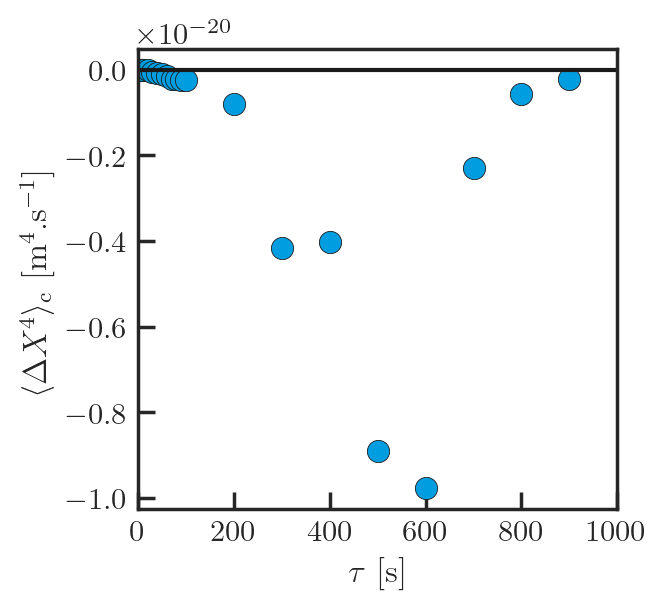

In [158]:
plt.figure(figsize=(1.8 * 3.375, 1.6* 3.375 / 1.68), tight_layout=True)
taille_marques=8

ax1 = plt.subplot(121)
ax1.plot(moments_bulk["tau"], C4_bulk, "o", color=BlueUB, markersize=taille_marques)
ax1.plot(np.linspace(0,1000, 1000), np.zeros(1000), "k-")
ax1.set(
    xlabel = r"$\tau~[\mathrm{s}]$",
    ylabel = r"$\langle \Delta X^4 \rangle_\mathrm{c} ~[\mathrm{m}^{4}.\mathrm{s}^{-1}]$",
    xlim=(0, 1000),
    # ylim=(9e-16,1e-6),
)
plt.savefig("Cumulant4_bulk.pdf")